In [1]:
# Run once only for flake8
%load_ext pycodestyle_magic
%pycodestyle_on or %flake8_on

In [2]:
import os
import numpy as np
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
import util_gmm as util_gmm
import warnings

from collections import defaultdict
from matplotlib import pyplot
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, \
    config_enumerate, infer_discrete, EmpiricalMarginal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer import Predictive

%matplotlib inline
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.5.1')
pyro.enable_validation(True)
warnings.filterwarnings("ignore")

## Gaussian Mixture Model for MovieLens dataset

__Overview:__ In this section, we will explore two different GMM models using different priors and inference methods; in attempt to cluster movies into different genres/release periods. We mainly focus on 5 features: revenue, budget, popularity, vote_count and vote average, using a subset of 1000 data points. Features are normalized by the mean and variance to standardize our hyperparameter values and avoid errors during numerical computation.

__Priors:__  We choose 5-10 cluster based on the fact that the top movie genres are: Comedy, Drama, Thriller, Action, Romance, Adventure, and we have release periods: 2010s, 2000s, 1990s, 1980s. 

In [3]:
movies_metadata_dir = os.path.join("data", "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
movies_metadata[["revenue", "budget", "vote_count",
                 "vote_average", "popularity"]].head()

,revenue,budget,vote_count,vote_average,popularity
0,373554033.0,30000000,5415.0,7.7,21.946943
1,262797249.0,65000000,2413.0,6.9,17.015539
2,81452156.0,16000000,34.0,6.1,3.859495
3,187436818.0,60000000,1886.0,7.7,17.924927
4,64350171.0,35000000,174.0,5.5,5.231580


### Experiment 1 (SVI and Normal Inverse-Gamma Prior):

### Model

Consider a standard GMM model. Given $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define our priors $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    \pi \sim Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$, and for each $\mu_k \in \mathbb{R}^D$:
\begin{equation}
    \mu_k \sim Normal(\mu_k | 0, I)
\end{equation}

and for each component $\sigma_k^2 \in \mathbb{R}^D$:
\begin{equation}
    \sigma_k^2 \sim InvGamma(\sigma_k^2 | 1, 1)
\end{equation}

In [4]:
data, data_new = util_gmm.get_train_test_split(movies_metadata)
K = 8  # Clusters
d = len(data[0])  # Dimensions
N = len(data)  # Length of data

In [5]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(
            locs[assignment], scale_), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'scale']))

### Inference

Here, we run SVI and compute the MAP estimates of the posterior for $p(\pi, \mu, \sigma^2|x_n)$.

In [6]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [7]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss


loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

seed = 87, init loss = 4406.3232421875


In [8]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

In [9]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

### Criticism:

The ELBO seems to decrease in general but increases midway. The gradients of the scale, locs and weights are noisy.

__Issues:__ The priors collapses to a local minimum during SVI, and we see that all clusters tend to converge to the same point. Furthermore, the Inverse Gamma prior for the variance does not capture cross-covariances between features, i.e. the GMM is not fully probabilistic.

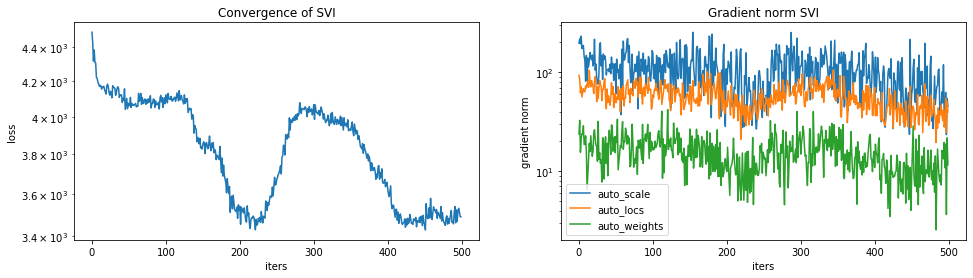

In [10]:
util_gmm.plot_svi_convergence(losses, gradient_norms)

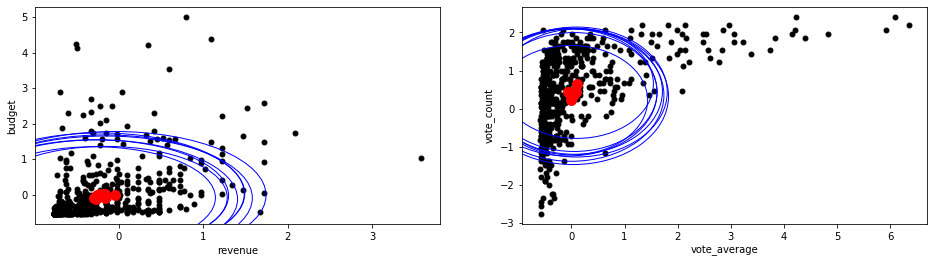

In [11]:
fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], locs[:, 0:2], scale, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], locs[:, 2:4], scale, K=K, d=d, ax=ax)

__Alternative:__ Consider MCMC for full posterior over components. For multivariate covariance matrix, a conjugate prior is the Inverse-Wishart distribution [Gelmen et al., 2003]. However, the Inverse Wishart is not a suitable prior. Firstly, positive-definite and symmetric constraints of the probability of generating valid samples is low using the Wishart. Secondly, the Wishart distribution is heavy-tailed; which are obstructions to ergodicity which is requirement for MCMC. When tails are heavy, samplers may drift around which can be difficult to return back to heavy mass, i.e. high computational costs.

__Solution:__ Try the LKJCorr Prior for full probabilistic covariance [Barnard, McCulloch & Meng, 2000]. The LKFCorr distribution has lighter tails which pairs better with MCMC. This uses the Cholesky factorization for faster computation, $\Sigma= L L^T$


### Experiment 2 (NUTS and Normal LKJ Correlation Cholesky Prior):

### Model
Given the same setup as before:
\begin{align}
    \pi &\sim Dir(\pi | \alpha \mathbb{1}_K) \\
    \mu_k &\sim Normal(\mu_k | 0, I)
\end{align}

Define the covariance matrix as:
\begin{equation}
    \Sigma = diag(\theta) \Omega diag(\theta) \iff \Omega_{i,j} = \Sigma_{i,j} (\theta_i \theta_j)^{-1}
\end{equation}

Set priors where $\theta_k$ is the scale vector and $\Omega$ is the correlation matrix defined by
\begin{align}
    \theta_k &\sim HalfCauchy(1) \\
    \Omega_k &\sim LKJCorr(\eta) \\
\end{align}

The LKJ correlation distribution is defined by
\begin{equation}
    LKJCorr(\Sigma | \eta) \propto det(\Sigma)^{\eta -1}
\end{equation}

In [12]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    theta = pyro.sample("theta", dist.HalfCauchy(1*torch.ones(d)).to_event(1))
    eta = torch.ones(1)
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), 1*torch.eye(d)))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(
            mu[assignment], scale_tril=L_Omega), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'L_omega']))

### Inference

__Steps:__ Run NUTS MCMC over 250 samples, draw the trace plots of the posterior samples and compute the Bayes estimate of $p(\pi, \mu, \Sigma|x_n)$.

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample:  67%|██████▋   | 200/300 [02:41,  1.46it/s, step size=3.88e-02, acc. prob=0.855]

In [ ]:
Sigma_samples = util_gmm.get_Sigma_samples(posterior_samples)
cov = util_gmm.get_bayes_estimate_cov(Sigma_samples, K)
mu = util_gmm.get_bayes_estimate_mu(posterior_samples)
pi = util_gmm.get_bayes_estimate_pi(posterior_samples)

In [ ]:
util_gmm.plot_mcmc_mu(posterior_samples, K, d)
util_gmm.plot_mcmc_pi(posterior_samples, K, d)
util_gmm.plot_mcmc_theta(posterior_samples, K, d)
util_gmm.plot_mcmc_Sigma(Sigma_samples, K, d)

### Criticism

__Results:__ After looking at the assignments of each movie using the trained GMM, we found that there is no significant pattern in genres/release periods, i.e. this is an issue of *non-identifiability*. However, the components of $\mu_k, \Sigma_k$ seem to capture the general distribution/shape of the data well looking at the trace plots. Most of the density in the GMM is clustered within a single component. 


In [ ]:
fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], mu[:, 0:2], cov, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], mu[:, 2:4], cov, K=K, d=d, ax=ax)

In [ ]:
predictive = Predictive(model, posterior_samples)
assignment = predictive.get_samples(data)["assignment"][-1, :]
pyplot.figure(figsize=(8, 4))
pyplot.hist(assignment, bins=K, ec="k")
pyplot.xlabel("pi")
pyplot.ylabel("Frequency")
pyplot.title("Components")
pyplot.show()

### Posterior Predictive Checks

__Steps:__ PPCs are a powerful model-checking procedure that performs the following: simulate replicated data from the posterior predictive distribution, compute a discrepancy that measures "relevance", and compare the distance between the discrepancy of observed and replicated data.

More formally, A PPC is defined by:
\begin{equation}
    PPC(x^{obs}; g, d) = E[g(d(x^{rep}, \theta), d(x^{obs}, \theta)) | x^{obs}]
\end{equation}
Where the realized discrepancy $d(y, \theta)$ is a function of both data and hidden variables [Ranganath & Blei, 2019] and $g(\cdot, \cdot)$ is a distance function.

One realized discrepancy is the log-likelihood for GMMs:
\begin{align}
    d(x, \theta) 
    &= \sum_{i=1}^{n} \log p(x_i | \theta) \\
    &= \sum_{i=i}^{n} \log \Big[ \sum_{k=1}^{K} \pi_k N(x_i; \mu_k, \Sigma_k) \Big]
\end{align}

In [ ]:
data_rep = []
for i in range(N):
    cluster = pyro.sample('category', dist.Categorical(torch.tensor(pi)))
    idx = cluster.item()
    sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    while sample[0] < min(data[:, 0]) or sample[1] < min(data[:, 1]):
        # Only sample valid points
        sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    data_rep.append(sample.tolist())
data_rep = torch.tensor(data_rep)

In [ ]:
d_obs = util_gmm.compute_log_likelihood(data, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

ppc = np.sqrt((d_obs - d_rep)**2)
print('Discrepancy of observed data: {}'.format(d_obs))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Posterior Predictive Check: {}'.format(ppc))

### Population Predictive Checks

__Issue__: PPCs tend to overfit due to "double dipping" the data, i.e. we compute the discrepancy of replicated data based on latent variables we obtained from the observed data.

__Solution__: Population Predictive Checks [Ranganath & Blei, 2019]. Use Bootstrap or Cross-validation to obtain $x^{new}$ to model the true distribution F. This follows the intuition: “If my model is good (in a relevant way) then data drawn from the posterior predictive distribution of a group will look like data from the true population of that group.”

A POP-PC is defined by
\begin{equation}
    POP-PC(x^{obs}, F; g, d) = E[g(d(x^{rep}, \theta), d(x^{new}, \theta)) | x^{obs}, F]
\end{equation}

In [ ]:
d_new = util_gmm.compute_log_likelihood(data_new, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

pop_pc = np.sqrt((d_new - d_rep)**2)
print('Discrepancy of new data: {}'.format(d_new))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Population Predictive Check: {}'.format(pop_pc))

### Hallucinated Data Simulation.

In [ ]:
fig = pyplot.figure(figsize=(16, 4))
ax1 = fig.add_subplot(
    121, xlabel="budget", ylabel="revenue",
    title="PPC", ylim=(-1, 6), xlim=(-1, 4))
ax1.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax1.scatter(data[:, 0], data[:, 1], label="observed data")
ax1.legend()
ax2 = fig.add_subplot(
    122, xlabel="budget", ylabel="revenue",
    title="POP-PC", ylim=(-1, 6), xlim=(-1, 4))
ax2.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax2.scatter(data_new[:, 0], data_new[:, 1], label="new data")
ax2.legend()

### Choosing number of clusters K based on PPC and POP-PC 

The data is collected by repeating the experiements above and changing the value of K to observe how PPCs/POP-PCs respond.

__Findings:__ In general, POP-PCs are higher than PPCs which is an expected result since we are evaluating the replicated data against new/unseen data. We observe that as $K$ increases from 10 onwards, the discrepancy of POP-PCs increases while PPCs do not increase as much; and the PPC/POP-PC scores are lowest between 6 to 10. Interestingly enough, there is a *Zig-Zag* pattern such that *even* numbers of clusters tend to have lower scores; and *odd* clusters tend to have higher scores. This suggests that the optimal number of clusters is either 6, 8 or 10.

In [ ]:
K_variable = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
ppc_response = [1028425, 499302, 2828440, 15175103, 15331, 30597838,
                4952241, 17231320, 6284324, 5327910, 4547856, 23852158,
                17231514]

pop_pc_response = [2522314, 833008, 1790494, 77044920, 3299700,
                   158990000, 8688746, 129820000, 1125285, 19079732,
                   30745118, 72734376, 94568328]

fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(
    111, xlabel="K number of clusters", ylabel="Discrepancy", title="POP-PC vs PPC")
ax.plot(K_variable, np.sqrt(ppc_response), label="PPC")
ax.plot(K_variable, np.sqrt(pop_pc_response), label="POP-PC")
ax.legend()
fig.show()

### Conclusion
* Non-identifiability of clusters is a challenge for clustering movies.
* LKJCorr prior captures full probabilistic covariance.
* Combining POP-PCs and PPCs to choose number of clusters.